In [37]:
library(bsts)
library(ggplot2)
library(reshape2)
ows_data = read.csv("ows_top300_words_time_series.csv", 
                    sep = ",",
                    header = T, 
                    stringsAsFactors = F, 
                    encoding= "utf-8")
ows_data = ows_data[,-c(1)]


ows_data <- log10(ows_data+0.0001)

In [38]:
head(ows_data)

ows,the,to,of,a,in.,is,occupy,and,for.,⋯,end,very,top,every,vote,needs,law,again,nArrests,tweets_number
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.700254,4.440200,4.224041,4.107922,4.001907,3.903849,4.010766,3.622835,3.920958,3.780245,⋯,2.707570,2.514548,2.409933,2.571709,2.212188,2.595496,2.296665,2.540330,1.255275,5.745943
4.819603,4.568366,4.331913,4.198602,4.134145,4.033062,4.145165,3.834484,4.042969,3.906712,⋯,2.739572,2.802774,2.545307,2.574031,2.539076,2.648360,2.269513,2.453318,-4.000000,5.864646
4.820753,4.530865,4.339332,4.206826,4.166785,4.047781,4.112672,3.772395,4.033182,3.916243,⋯,2.967080,2.598791,2.545307,2.673942,2.635484,2.603144,2.130334,2.522444,-4.000000,5.872110
4.814367,4.559548,4.362878,4.255465,4.220474,4.044305,4.168674,3.784261,4.063033,3.907949,⋯,2.743510,2.695482,2.588832,2.624282,2.706718,2.602060,2.365488,2.428135,-4.000000,5.874289
4.897995,4.638918,4.425029,4.291724,4.237418,4.096632,4.218772,3.983581,4.129722,4.037825,⋯,2.851870,2.649335,2.989450,2.613842,3.153510,2.764176,2.451787,2.561102,1.505151,5.952243
4.831050,4.561292,4.368287,4.237870,4.128238,4.087817,4.153449,3.870228,4.066996,4.013090,⋯,2.703291,2.727541,2.916454,2.650308,2.926342,2.711807,2.403121,2.532755,2.178977,5.892609


In [39]:
ss <- AddLocalLinearTrend(list(), ows_data$tweets_number)
ss <- AddSeasonal(ss, ows_data$tweets_number, nseasons = 10)
bsts.reg <- bsts(tweets_number ~ ., data = ows_data,
                 state.specification = ss, 
                 niter = 1000, ping= 0, seed = 1)

In [40]:
### Get the number of burn-ins to discard
burn <- SuggestBurn(0.1, bsts.reg)

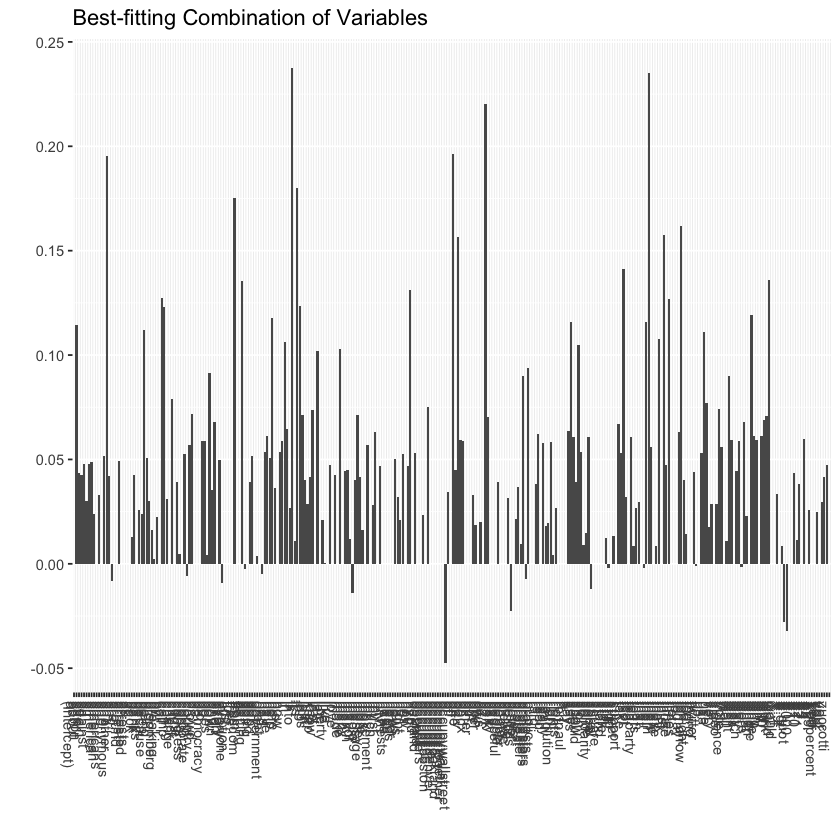

In [41]:
### Helper function to get the positive mean of a vector
PositiveMean <- function(b) {
  b <- b[abs(b) > 0]
  if (length(b) > 0) 
    return(mean(b))
  return(0)
}
### Get the average coefficients when variables were selected (non-zero slopes)
coeff <- data.frame(melt(apply(bsts.reg$coefficients[-(1:burn),], 2, PositiveMean)))
coeff$Variable <- as.character(row.names(coeff))
ggplot(data=coeff, aes(x=Variable, y=value)) + 
  geom_bar(stat="identity", position="identity") + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
  xlab("") + ylab("") + ggtitle("Best-fitting Combination of Variables")

In [42]:
#abs(coeff$value)
coeff[order(abs(coeff$value)),]


,value,Variable
,<dbl>,<chr>
(Intercept),0,(Intercept)
X.quot,0,X.quot
occupywallstreet,0,occupywallstreet
police,0,police
people,0,people
now,0,now
out,0,out
occupyoakland,0,occupyoakland
nypd,0,nypd


In [43]:
### Inclusion probabilities -- i.e., how often were the variables selected 
inclusionprobs <- melt(colMeans(bsts.reg$coefficients[-(1:burn),] != 0))
inclusionprobs$Variable <- as.character(row.names(inclusionprobs))
# ggplot(data=inclusionprobs, aes(x=Variable, y=value)) + 
#   geom_bar(stat="identity", position="identity") + 
#   theme(axis.text.x=element_text(angle = -90, hjust = 0)) + 
#   xlab("") + ylab("") + ggtitle("Best-fitting Combination of Variables")

In [62]:
ss0 <- AddLocalLevel(list(), ows_data$tweets_number)
ss1 <- AddSeasonal(ss0, y = ows_data$tweets_number, nseasons = 10, season.duration = 2)
trend.model <- bsts(ows_data$tweets_number, ss0, niter = 1000, seed = 1)
trend.seasonal.model <- bsts(ows_data$tweets_number, ss1, niter = 1000, seed = 1)

# #model1<- bsts(tweets_number ~ ows_data[,"country"], data = ows_data, niter = 1000, state.specification=ss0,
#               expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 06:15:35 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 06:15:35 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 06:15:35 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 06:15:35 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 06:15:35 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 06:15:35 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 06:15:35 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 06:15:35 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 06:15:36 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 06:15:36 2021 =-=-=-=-=
=-=-=-=-= Iteration 0 Sat Oct  2 06:15:36 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 06:15:36 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 06:15:36 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 06:15:37 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 06:15:37 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 06:15:37 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 06:15:37 2021 =-=-=-=-=
=

In [63]:
mod1<- bsts(tweets_number ~ ows_data[,"country"]+ ows_data[,"congress"],
              data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 06:16:14 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 06:16:14 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 06:16:14 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 06:16:15 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 06:16:15 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 06:16:15 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 06:16:15 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 06:16:15 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 06:16:15 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 06:16:15 2021 =-=-=-=-=


In [64]:
mod2<- bsts(tweets_number ~ ows_data[,"people"]+ ows_data[,"job"],
              data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 06:16:42 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 06:16:42 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 06:16:42 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 06:16:42 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 06:16:42 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 06:16:43 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 06:16:43 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 06:16:43 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 06:16:43 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 06:16:43 2021 =-=-=-=-=


In [65]:
mod3<- bsts(tweets_number ~ ows_data[,"ows"]+ ows_data[,"peaceful"],
              data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 06:16:59 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 06:16:59 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 06:17:00 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 06:17:00 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 06:17:00 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 06:17:00 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 06:17:00 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 06:17:00 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 06:17:00 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 06:17:00 2021 =-=-=-=-=


In [45]:
model2<- bsts(tweets_number ~ ows_data[,"country"]+ ows_data[, "job"], 
              data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3,  seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:39:41 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:39:41 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:39:41 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:39:41 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:39:41 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:39:42 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:39:42 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:39:42 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:39:42 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:39:42 2021 =-=-=-=-=


In [46]:
model3<- bsts(tweets_number ~ ows_data[,"country"]+ ows_data[,"job"]+ ows_data[,"congress"],
              data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:39:44 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:39:44 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:39:44 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:39:44 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:39:44 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:39:44 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:39:44 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:39:45 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:39:45 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:39:45 2021 =-=-=-=-=


In [47]:
model4<- bsts(tweets_number ~ ows_data[,"country"]+ ows_data[,"job"]+ ows_data[,"congress"]+ ows_data[,"peaceful"],
              data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:39:47 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:39:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:39:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:39:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:39:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:39:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:39:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:39:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:39:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:39:49 2021 =-=-=-=-=


In [48]:
model5<- bsts(tweets_number ~ ows_data[,"country"]+ ows_data[,"job"]+ ows_data[,"congress"]+ ows_data[,"peaceful"]+ ows_data[,"ows"],
              data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:39:51 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:39:51 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:39:51 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:39:51 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:39:51 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:39:52 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:39:52 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:39:52 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:39:52 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:39:52 2021 =-=-=-=-=


In [49]:
model6<- bsts(tweets_number ~ ows_data[,"country"]+ ows_data[,"job"]+ ows_data[,"congress"]+ ows_data[,"peaceful"]+ ows_data[,"ows"]+ ows_data[,"people"],
              data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:39:53 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:39:53 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:39:54 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:39:54 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:39:54 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:39:54 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:39:54 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:39:54 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:39:54 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:39:55 2021 =-=-=-=-=


In [50]:
model <- bsts(tweets_number ~ ., data = ows_data,
              niter = 1000, state.specification=ss0,
              expected.model.size = 3,
              seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:39:55 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:39:56 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:39:56 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:39:57 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:39:57 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:39:57 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:39:58 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:39:58 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:39:59 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:39:59 2021 =-=-=-=-=


In [56]:
model_1<- bsts(tweets_number ~ ows_data[,"n17"],
               data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:51:05 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:51:05 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:51:06 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:51:06 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:51:06 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:51:06 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:51:06 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:51:06 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:51:06 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:51:06 2021 =-=-=-=-=


In [57]:
model_2<- bsts(tweets_number ~ ows_data[,"n17"]+ows_data[,"tomorrow"],
               data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:51:29 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:51:29 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:51:29 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:51:29 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:51:29 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:51:29 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:51:29 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:51:29 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:51:30 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:51:30 2021 =-=-=-=-=


In [58]:
model_3<- bsts(tweets_number ~ ows_data[,"n17"]+ows_data[,"tomorrow"]+ows_data[,"arrested"],
               data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:51:49 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:51:49 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:51:49 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:51:49 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:51:49 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:51:50 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:51:50 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:51:50 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:51:50 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:51:50 2021 =-=-=-=-=


In [59]:
model_4<- bsts(tweets_number ~ ows_data[,"n17"]+ows_data[,"tomorrow"]+ows_data[,"arrested"]+ows_data[,"party"],
               data = ows_data, niter = 1000, state.specification=ss0,
              expected.model.size = 3, seed = 1)

=-=-=-=-= Iteration 0 Sat Oct  2 05:52:12 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:52:12 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:52:12 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:52:12 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:52:12 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:52:13 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:52:13 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:52:13 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:52:13 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:52:13 2021 =-=-=-=-=


Warning message in min(ows_data$daliy_tweets):
“min里所有的参数都不存在; 回覆Inf”Warning message in max(ows_data$daliy_tweets):
“max里所有的参数都不存在；回覆-Inf”

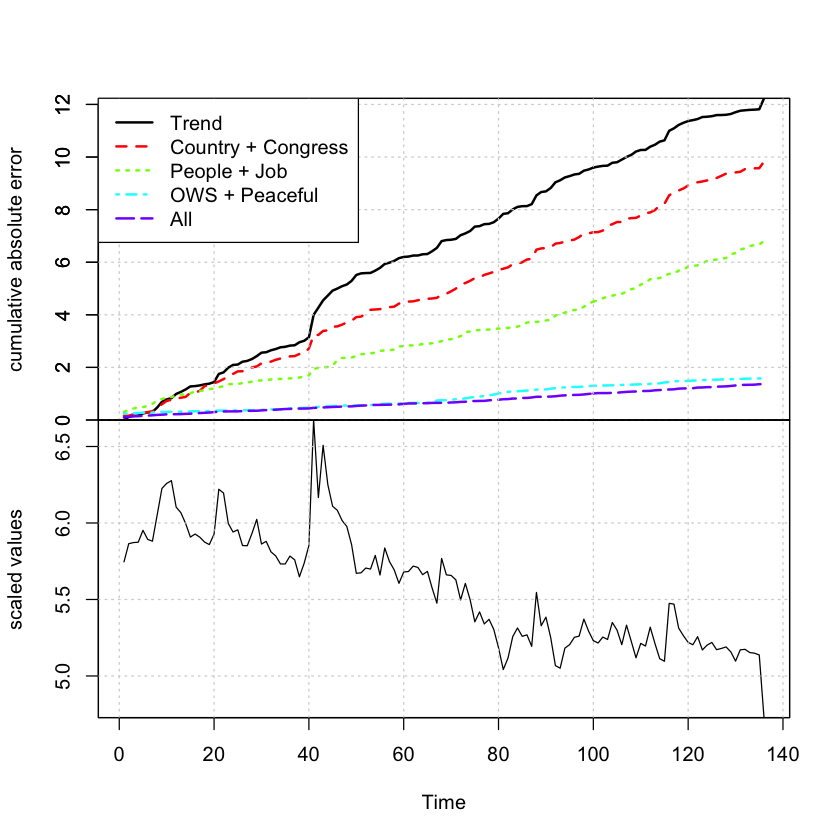

In [68]:
CompareBstsModels(list("Trend" = trend.model,
                       #"trend and seasonal" = trend.seasonal.model,
                       "Country + Congress"=mod1,
                       "People + Job"=mod2,
                       "OWS + Peaceful"=mod3,
#                        "model4"=model4,
#                        "model5"=model5,
#                        "model6"=model6,
                       "All"=model), 
                  xlab = "Time",
                  burn = 150)
scope = c(min(ows_data$daliy_tweets), max(ows_data$daliy_tweets))
r.square = function(model) as.character(round(summary(model)$relative.gof, 3))

In [69]:
pdf(file = "图7-3_ows_log_group.pdf",   # The directory you want to save the file in
    width = 8, # The width of the plot in inches
    height = 8) # The height of the plot in inches


CompareBstsModels(list("Trend" = trend.model,
                       #"trend and seasonal" = trend.seasonal.model,
                       "Country + Congress"=mod1,
                       "People + Job"=mod2,
                       "OWS + Peaceful"=mod3,
                       "All"=model), 
                  xlab = "Time",
                  burn = 150)
# Step 3: Run dev.off() to create the file!
dev.off()

pdf 
  2

Warning message in min(ows_data$daliy_tweets):
“min里所有的参数都不存在; 回覆Inf”Warning message in max(ows_data$daliy_tweets):
“max里所有的参数都不存在；回覆-Inf”

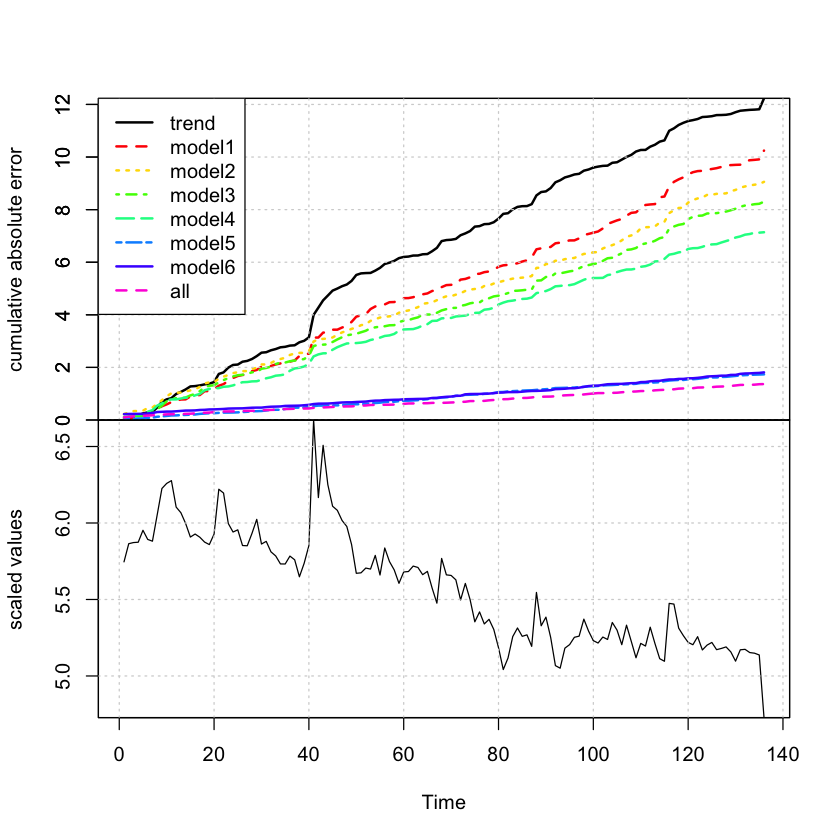

In [51]:
CompareBstsModels(list(trend = trend.model,
                       #"trend and seasonal" = trend.seasonal.model,
                       "model1"=model1,
                       "model2"=model2,
                       "model3"=model3,
                       "model4"=model4,
                       "model5"=model5,
                       "model6"=model6,
                       "all"=model), 
                  xlab = "Time",
                  burn = 150)
scope = c(min(ows_data$daliy_tweets), max(ows_data$daliy_tweets))
r.square = function(model) as.character(round(summary(model)$relative.gof, 3))

In [61]:
help(CompareBstsModels)

In [55]:
pdf(file = "图7-3_ows_log.pdf",   # The directory you want to save the file in
    width = 8, # The width of the plot in inches
    height = 8) # The height of the plot in inches

CompareBstsModels(list(trend = trend.model,
                       #"trend and seasonal" = trend.seasonal.model,
                       "model1"=model1,
                       "model2"=model2,
                       "model3"=model3,
                       "model4"=model4,
                       "model5"=model5,
                       "model6"=model6,
                       "all"=model), 
                  xlab = "Time",
                  burn = 150)
scope = c(min(ows_data$daliy_tweets), max(ows_data$daliy_tweets))
r.square = function(model) as.character(round(summary(model)$relative.gof, 3))

# Step 3: Run dev.off() to create the file!
dev.off()

Warning message in min(ows_data$daliy_tweets):
“min里所有的参数都不存在; 回覆Inf”Warning message in max(ows_data$daliy_tweets):
“max里所有的参数都不存在；回覆-Inf”

pdf 
  2

In [60]:
pdf(file = "图7-3_ows_log_selected.pdf",   # The directory you want to save the file in
    width = 8, # The width of the plot in inches
    height = 8) # The height of the plot in inches

CompareBstsModels(list(trend = trend.model,
                       #"trend and seasonal" = trend.seasonal.model,
                       "model1"=model_1,
                       "model2"=model_2,
                       "model3"=model_3,
                       "model4"=model_4,
                       #"model5"=model5,
                       #"model6"=model6,
                       "all"=model), 
                  xlab = "Time",
                  burn = 150)
scope = c(min(ows_data$daliy_tweets), max(ows_data$daliy_tweets))
r.square = function(model) as.character(round(summary(model)$relative.gof, 3))

# Step 3: Run dev.off() to create the file!
dev.off()

Warning message in min(ows_data$daliy_tweets):
“min里所有的参数都不存在; 回覆Inf”Warning message in max(ows_data$daliy_tweets):
“max里所有的参数都不存在；回覆-Inf”

pdf 
  2

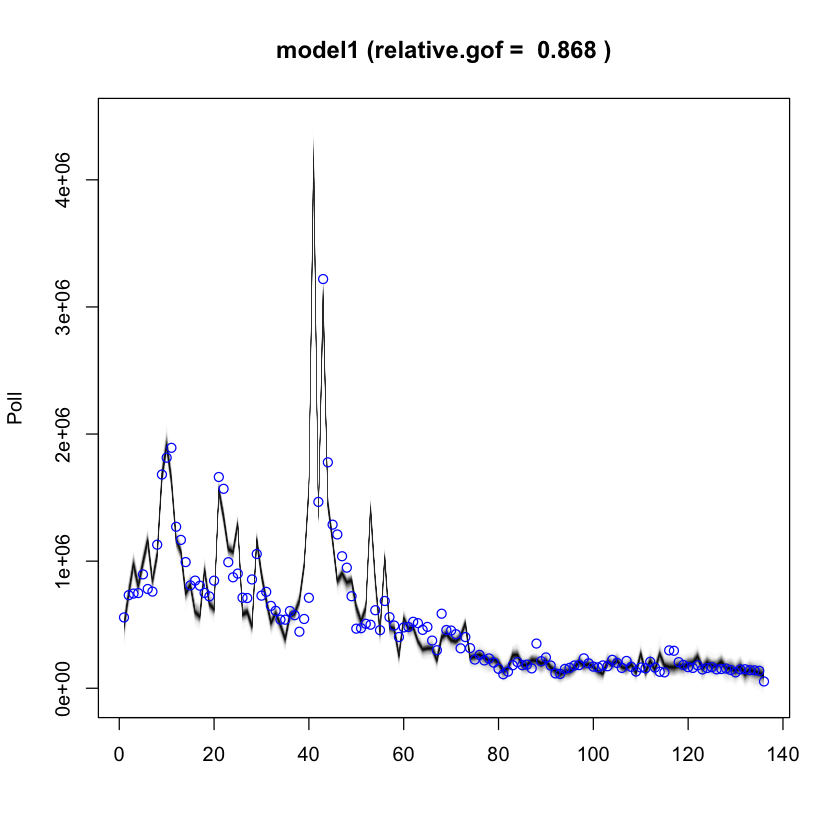

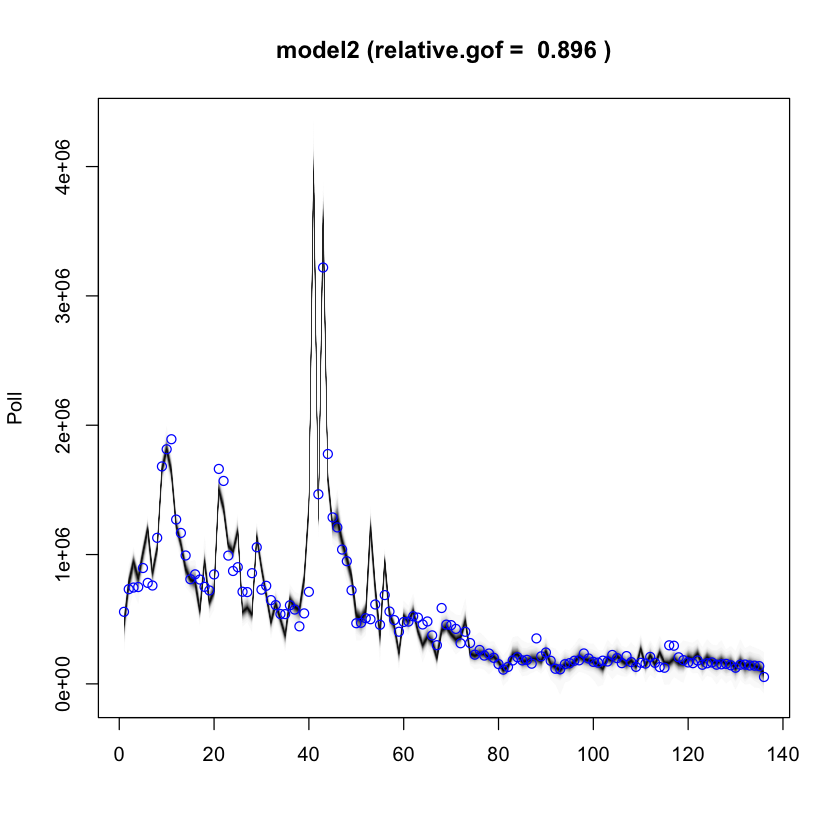

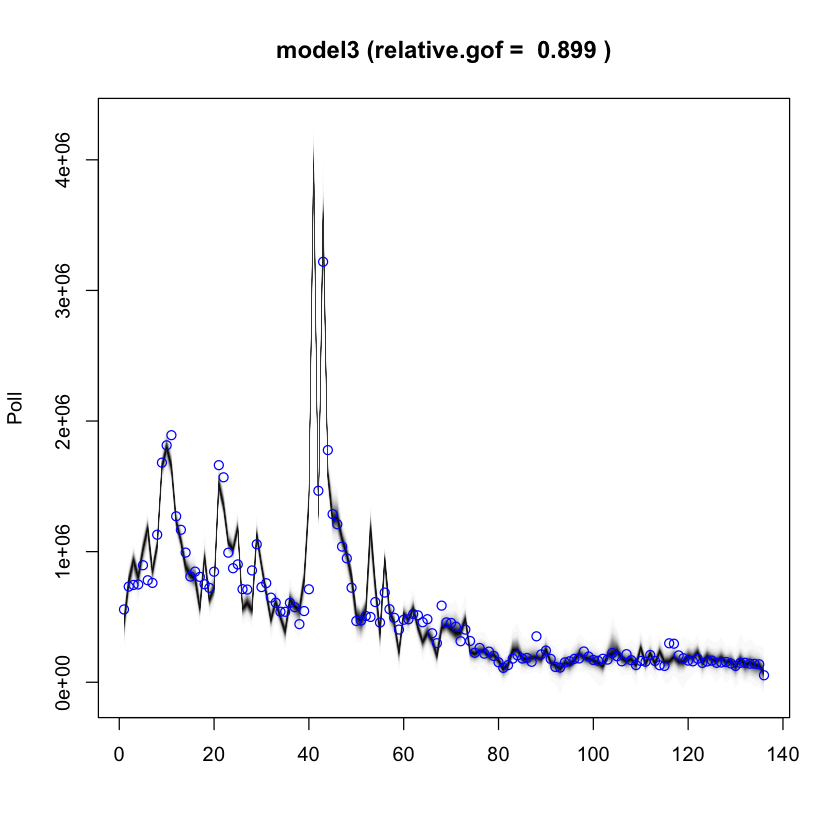

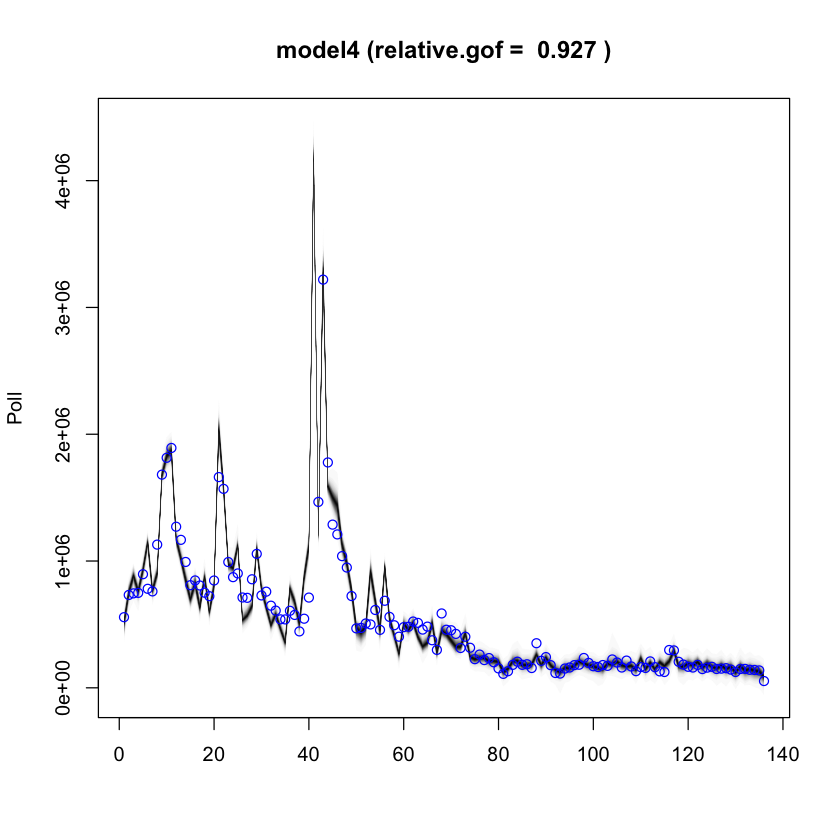

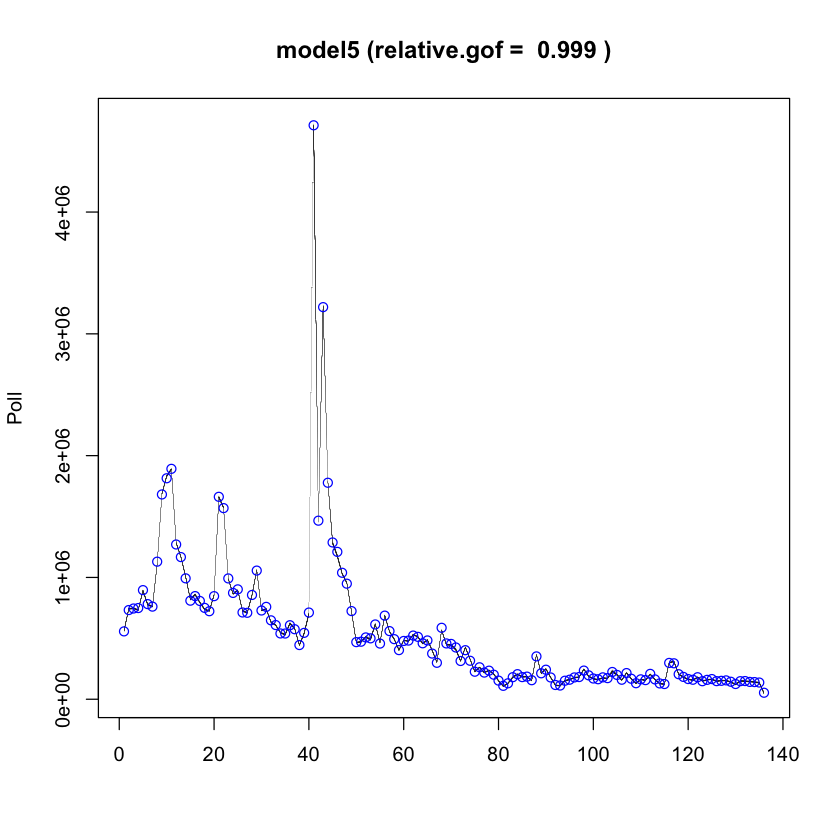

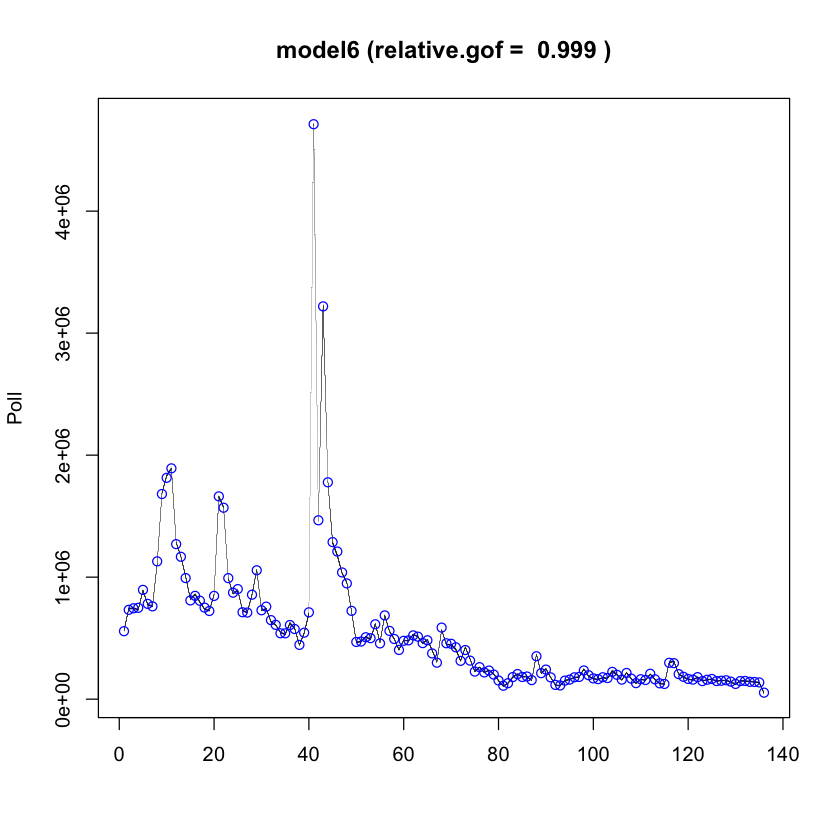

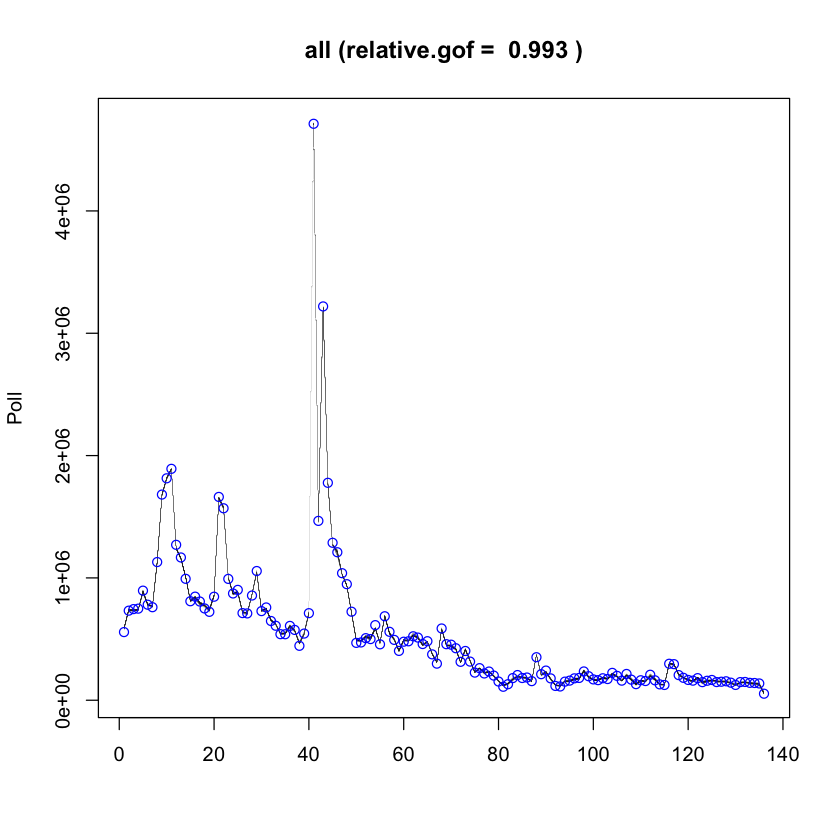

In [29]:
plot(model1, ylim = scope, main = paste('model1 (relative.gof = ', r.square(model1), ')'), xlab = "", ylab = "Poll")
plot(model2, ylim = scope, main = paste('model2 (relative.gof = ', r.square(model2), ')'), xlab = "", ylab = "Poll")
plot(model3, ylim = scope, main = paste('model3 (relative.gof = ', r.square(model3), ')'), xlab = "", ylab = "Poll")
plot(model4, ylim = scope, main = paste('model4 (relative.gof = ', r.square(model4), ')'), xlab = "", ylab = "Poll")
plot(model5, ylim = scope, main = paste('model5 (relative.gof = ', r.square(model5), ')'), xlab = "", ylab = "Poll")
plot(model6, ylim = scope, main = paste('model6 (relative.gof = ', r.square(model6), ')'), xlab = "", ylab = "Poll")
plot(model, ylim = scope, main = paste('all (relative.gof = ', r.square(model), ')'), xlab = "", ylab = "Poll")

=-=-=-=-= Iteration 0 Sat Oct  2 05:27:20 2021 =-=-=-=-=
=-=-=-=-= Iteration 100 Sat Oct  2 05:27:21 2021 =-=-=-=-=
=-=-=-=-= Iteration 200 Sat Oct  2 05:27:22 2021 =-=-=-=-=
=-=-=-=-= Iteration 300 Sat Oct  2 05:27:23 2021 =-=-=-=-=
=-=-=-=-= Iteration 400 Sat Oct  2 05:27:24 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sat Oct  2 05:27:25 2021 =-=-=-=-=
=-=-=-=-= Iteration 600 Sat Oct  2 05:27:27 2021 =-=-=-=-=
=-=-=-=-= Iteration 700 Sat Oct  2 05:27:28 2021 =-=-=-=-=
=-=-=-=-= Iteration 800 Sat Oct  2 05:27:29 2021 =-=-=-=-=
=-=-=-=-= Iteration 900 Sat Oct  2 05:27:30 2021 =-=-=-=-=


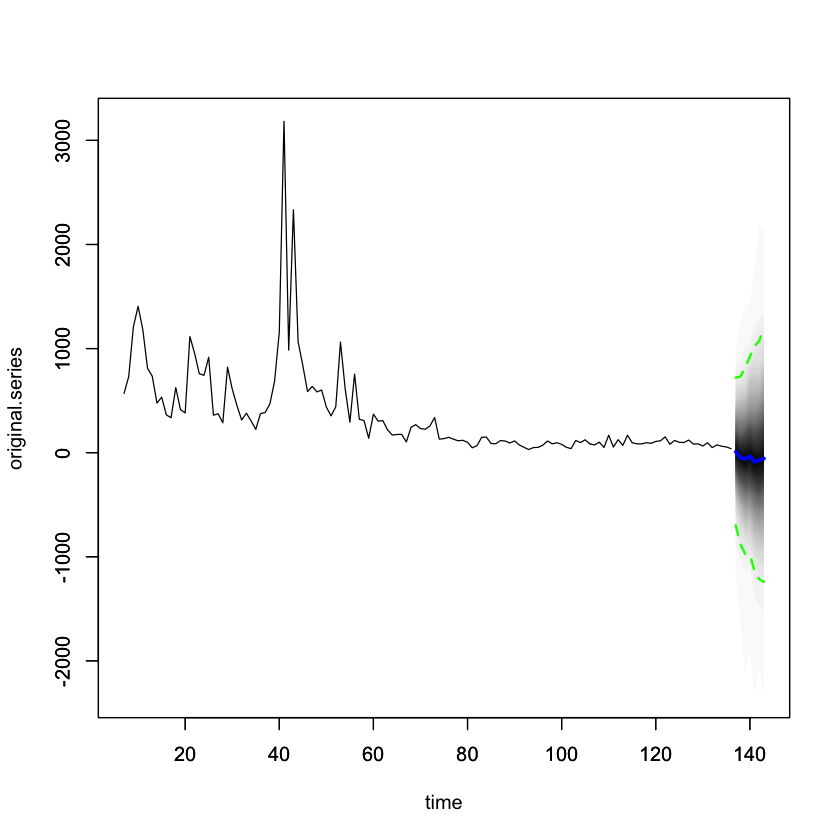

In [30]:
ss <- AddLocalLinearTrend(list(), ows_data$country)
ss <- AddSeasonal(ss, ows_data$country, nseasons = 52)
model_pred <- bsts(ows_data$country,
               state.specification = ss,
               niter = 1000)
pred1 <- predict(model_pred, horizon = 7, burn = 100)
plot(pred1, plot.original = 130)